In [13]:
import os
import gzip
import re
from pathlib import Path
from io import BytesIO
from zipfile import ZipFile

import zarr
import h5py
import dotenv
import nilearn.image
import skimage.measure
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from p_tqdm import p_map
from nibabel.orientations import ornt_transform, axcodes2ornt, inv_ornt_aff, apply_orientation, io_orientation, aff2axcodes

dotenv.load_dotenv()


True

In [14]:
DATA = Path(os.getenv('DATA'))
out_dir = DATA/'interim/petct'
project = 'TUE1015TSMEL'
zip_archive = DATA/f'raw/{project}.zip'

In [15]:
def read_nifti_from_zip(zip_obj, file_path):
    with zip_obj.open(file_path, 'r') as zfile:
        gzfile = gzip.GzipFile(fileobj=BytesIO(zfile.read()), mode='rb')
        fh = nib.FileHolder(fileobj=BytesIO(gzfile.read()))
        img_file = nib.Nifti1Image.from_file_map({'header': fh, 'image': fh, 'affine': fh})
        return img_file

In [16]:
def reorient_nifti(img,
                   target_orientation=('L', 'A', 'S'),
                   verbose=False):
    new_ornt = axcodes2ornt(target_orientation)
    vox_array = img.get_fdata()
    affine = img.affine
    orig_ornt = io_orientation(img.affine)
    ornt_trans = ornt_transform(orig_ornt, new_ornt)
    orig_shape = vox_array.shape
    new_vox_array = apply_orientation(vox_array, ornt_trans)
    aff_trans = inv_ornt_aff(ornt_trans, orig_shape)
    new_affine = np.dot(affine, aff_trans)
    if verbose:
        print(f'{aff2axcodes(affine)} -> {aff2axcodes(new_affine)}')
    new_img = nib.Nifti1Image(new_vox_array, new_affine, img.header)
    return new_img

In [17]:
def normalize_nifti(img, arr_min=-1000, arr_max=1000, dtype=np.float32):
    affine = img.affine
    arr = img.get_fdata()
    arr -= arr_min
    arr *= (1 / (arr_max - arr_min))
    arr = np.clip(arr, 0, 1)
    return nib.Nifti1Image(arr.astype(dtype), affine)

In [18]:
def isocont(img, mask, percentile_threshold=25):
    # compute connected components
    mask_comp, num_comp = skimage.measure.label(mask, neighbors=None, background=None,
                                                return_num=True, connectivity=None)
    mask_th = np.zeros_like(mask)

    for comp in range(num_comp):
        sel_comp = (mask_comp == (comp + 1))
        suv_values = img[sel_comp]
        th = np.percentile(suv_values, percentile_threshold)
        mask_th = mask_th + np.logical_and(np.greater_equal(img, th), sel_comp)
    mask_th = mask_th.astype(np.uint8)
    return mask_th

In [19]:
# parse zipped files
files = {'key': [], 'petsuv': [], 'ct': [], 'mask': []}
with ZipFile(zip_archive, 'r') as zf:
    complete_name_list = zf.namelist()
petsuv_list = list(filter(re.compile('.*petsuv.nii.gz').match, complete_name_list))
for petsuv_path in petsuv_list:
    petsuv_path = Path(petsuv_path)
    files['ct'].append(str(petsuv_path.parent/petsuv_path.name.replace('petsuv', 'ct')))
    files['petsuv'].append(str(petsuv_path))
    files['mask'].append(str(petsuv_path.parent/petsuv_path.name.replace('petsuv', 'mask')))
    files['key'].append(petsuv_path.parent.name)
df_files = pd.DataFrame.from_dict(files)
subjects = [[subject['key'], subject['petsuv'], subject['ct'], subject['mask']] for index, subject in df_files.iterrows()]

In [28]:
target_orientation = ('L','A','S')
target_spacing = (2.0, 2.0, 3.0)
ct_norm = (-1000.0, 1000.0)
pet_norm = (0.0, 40.0)
p_threshold = 25
zarr_path = out_dir/'TUE1015TSMEL_3D.zarr'
h5_path = out_dir/'TUE001XTSXXX_3D.h5'

In [21]:
def process_subject(subject):
    key, petsuv_path, ct_path , mask_path = tuple(subject)

    # read data from zip file
    with ZipFile(zip_archive, 'r') as zip_obj:
        petsuv = read_nifti_from_zip(zip_obj, petsuv_path)
        ct = read_nifti_from_zip(zip_obj, ct_path)
        mask = read_nifti_from_zip(zip_obj, mask_path)

    # reorient niftis
    ct = reorient_nifti(ct, target_orientation=target_orientation)
    petsuv = reorient_nifti(petsuv, target_orientation=target_orientation)
    mask = reorient_nifti(mask, target_orientation=target_orientation)

    # resample and align pet/ct
    orig_spacing = np.array(ct.header.get_zooms())
    orig_shape = ct.header.get_data_shape()
    target_affine = np.copy(ct.affine)
    target_affine[:3, :3] = np.diag(target_spacing / orig_spacing) @ ct.affine[:3, :3]
    target_shape = (orig_shape*(orig_spacing/target_spacing)).astype(np.int)

    ct_rs = nilearn.image.resample_img(ct, target_affine, target_shape,
                                    interpolation='continuous',
                                    fill_value=-1024)
    ct_rs = normalize_nifti(ct_rs, ct_norm[0], ct_norm[1])

    petsuv_rs = nilearn.image.resample_to_img(petsuv, ct_rs,
                                            interpolation='continuous',
                                            fill_value=0)
    petsuv_rs = normalize_nifti(petsuv_rs, pet_norm[0], pet_norm[1])

    mask_rs = nilearn.image.resample_to_img(mask, ct_rs,
                                            interpolation='nearest',
                                            fill_value=0)

    # concat pet/ct to one array and save with zarr
    pet_data = petsuv_rs.get_fdata().astype(np.float16)
    ct_data = ct_rs.get_fdata().astype(np.float16)
    data = np.stack([pet_data, ct_data])
    affine = petsuv_rs.affine.tolist()

    # compute isomask
    mask_data = mask_rs.get_fdata().astype(np.uint8)
    mask_iso_data = isocont(pet_data, mask_data, percentile_threshold=p_threshold)
    mask_data = mask_data[np.newaxis, ...]
    mask_iso_data = mask_iso_data[np.newaxis, ...]
    
    with zarr.open(str(zarr_path)) as zf:
        group = zf.require_group('image')
        ds = group.zeros(key, shape=data.shape, dtype=data.dtype, 
                        chunks=False, overwrite=True)
        ds[:] = data
        ds.attrs['affine'] = affine
        ds.attrs['project'] = project

        group = zf.require_group('mask')
        ds = group.zeros(key, shape=mask_data.shape, dtype=mask_data.dtype, 
                        chunks=False, overwrite=True)
        ds[:] = mask_data
        ds.attrs['affine'] = affine
        ds.attrs['project'] = project

        group = zf.require_group('mask_iso')
        ds = group.zeros(key, shape=mask_iso_data.shape, dtype=mask_iso_data.dtype, 
                        chunks=False, overwrite=True)
        ds[:] = mask_iso_data
        ds.attrs['affine'] = affine
        ds.attrs['project'] = project

In [22]:
# multiprocessing
res = p_map(process_subject, subjects, num_cpus=10)

In [29]:
# copy to hdf5
zarr.copy_all(zarr.open(str(zarr_path)), h5py.File(h5_path, 'a'))

(183, 0, 8445549678)

In [38]:
# write keys to file
with h5py.File(h5_path, 'r') as hf:
    keys = [f + '\n' for f in list(hf['image'])]
    with open(out_dir/'keys'/(h5_path.stem + '_all.dat'), 'w') as key_file:
        key_file.writelines(keys)

PosixPath('/mnt/qdata/raheppt1/data/tumorvolume/interim/petct/keys/TUE001XTSXXX_3D_all.dat')

### Testing

In [52]:
with h5py.File(h5_path, 'r') as hf:
    keys = list(hf['image'])
    print(len(keys))
    key = keys[300]
    img = hf[f'image/{key}'][:].astype(np.float32)
    mask = hf[f'mask/{key}'][:].astype(np.uint8)
    mask_iso = hf[f'mask_iso/{key}'][:].astype(np.uint8)

499


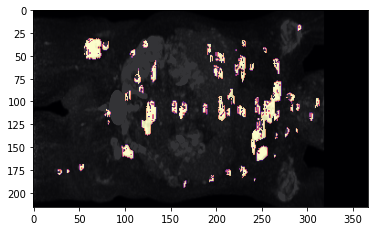

In [53]:
plt.imshow(img[0].max(axis=1), cmap='gray', vmin=0, vmax=0.1)
plt.imshow((mask-mask_iso).max(axis=1), cmap='magma', alpha=0.8)